# Magic and loading data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

%matplotlib inline

In [11]:
# runtime needs to be restarted after running this cell

!pip install arch yfinance pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

In [13]:
# importing data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
data = pd.read_excel('/content/drive/MyDrive/07 - Six - Team only/Raw data copy/Time_Series_Merchants_Transactions_Anonymized.xlsx',)

# Exploratory Data Analysis

## DataFrame formatting

In [15]:
# replacing index

data = data.set_index('Merchant Name')

In [16]:
# replacing columns names with standard date format

dates = pd.date_range(start='2020-08', end='2022-10', freq="M")
data.columns = dates

In [17]:
data.head()

,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
Merchant Name,,,,,,,,,,,,,,,,,,,,,
Merchant 1,416772.0,395324.0,411329.0,475679.0,497747.0,445429.0,505033.0,477349.0,496073.0,576800.0,...,644293.0,700144.0,611675.0,639038.0,616915.0,686572.0,630707.0,622073.0,667523.0,668189.0
Merchant 2,21.0,24.0,13.0,21.0,4.0,80.0,1.0,24.0,183.0,31.0,...,11.0,119.0,62.0,52.0,432.0,86.0,108.0,72.0,101.0,80.0
Merchant 3,1.0,1.0,0.0,0.0,50.0,3.0,4.0,4.0,0.0,16.0,...,50.0,0.0,0.0,0.0,0.0,0.0,49.0,1.0,1.0,0.0
Merchant 4,159.0,168.0,155.0,152.0,160.0,149.0,147.0,152.0,170.0,150.0,...,175.0,159.0,180.0,162.0,183.0,172.0,198.0,183.0,226.0,185.0
Merchant 5,70.0,27.0,60.0,63.0,80.0,57.0,75.0,73.0,85.0,96.0,...,132.0,147.0,129.0,127.0,131.0,159.0,150.0,160.0,154.0,168.0


# M1 data to use

In [18]:
# M1 = Merchant 1

df = pd.DataFrame(data.T.iloc[:,0])
df.index.name = 'Month'
df.head()

,Merchant 1
Month,
2020-08-31,416772.0
2020-09-30,395324.0
2020-10-31,411329.0
2020-11-30,475679.0
2020-12-31,497747.0


# M1 ADFTest Autoregression

## Non-stationary

In [19]:
def test_stationarity(time_series):
  movingAVG = time_series.rolling(window=12).mean()
  movingSTD = time_series.rolling(window=12).std()
  orig = plt.plot(time_series, color='black', label='Original')
  mean = plt.plot(movingAVG, color='red', label='Mean')
  std = plt.plot(movingSTD, color='blue', label='Std')
  plt.legend(loc='best')
  plt.title('Rolling mean and STD')
  plt.show(block=False)

  print('Results of Dicky-Fuller Test:')
  dftest = adfuller(time_series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test statistics', 'p-value', '#lag used', 'n. observations used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

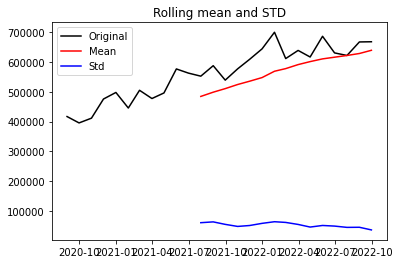

Results of Dicky-Fuller Test:
Test statistics         -1.572944
p-value                  0.497169
#lag used                1.000000
n. observations used    24.000000
Critical Value (1%)     -3.737709
Critical Value (5%)     -2.992216
Critical Value (10%)    -2.635747
dtype: float64


In [20]:
test_stationarity(df)

# H => data is not stationary
# Ha => data is stationary

# test statistics > critical values => failed to reject the null hypothesis
# data is non-stationary

In [21]:
# check for autoregressive time series model

adft = ADFTest()
adft.is_stationary(df['Merchant 1'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  after removing the cwd from sys.path.


(0.42770926245830787, True)

In [22]:
adft.should_diff(df['Merchant 1'])

(0.42770926245830787, True)

# M1 Autoregressive integrated moving average models

## ARIMA

In [23]:
# p = number of lag observations included in the model
# d = number of times that the raw observation are differenced
# q = size of moving average window (order of moving average)

In [24]:
# ARIMA model setup

ARIMA_model = auto_arima(df['Merchant 1'], 
                      start_p=1, 
                      start_q=1,
                      test='adf',             # automatic optimal d through adftest
                      max_p=3, max_q=3,       # max p and q
                      m=12,                   # period of seasonal differencing (monthly=12)
                                              # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,                 # automatic optimal 'd' from model
                      seasonal=False,         # no Seasonality for standard ARIMA
                      trace=False,            # logs 
                      error_action='warn',    # shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)          # identifies optimal model parameters

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


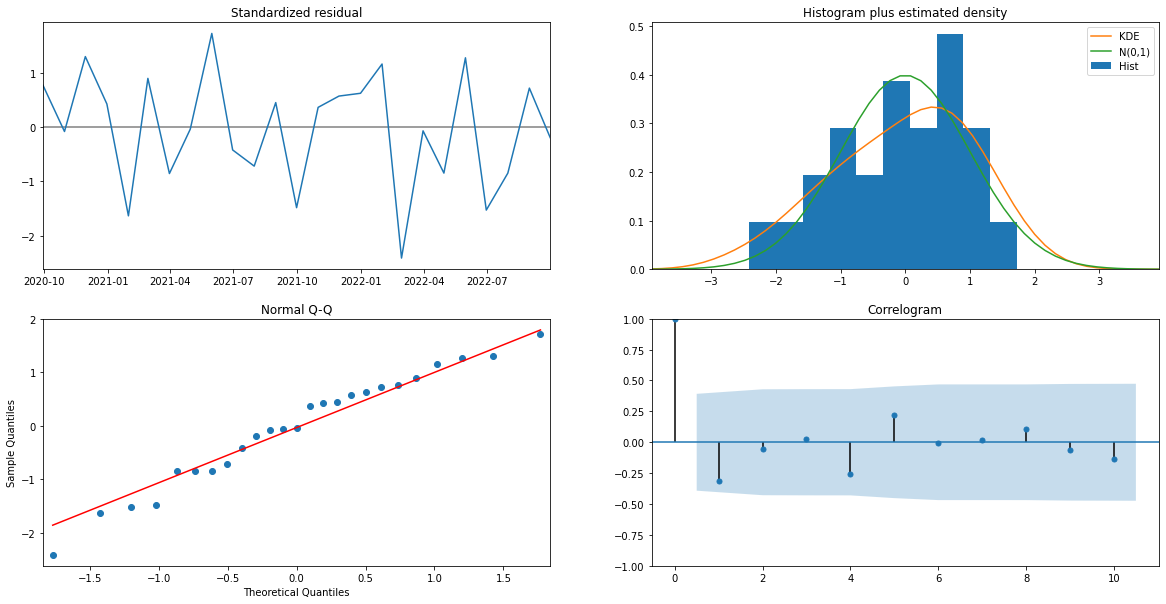

In [25]:
# ARIMA model diagnostics

ARIMA_model.plot_diagnostics(figsize=(20,10))
plt.show()

In [26]:
# ARIMA model summary

ARIMA_model.summary()

# for M1 p-value > 0.05 => not significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -300.901
Date:                Tue, 22 Nov 2022   AIC                            607.801
Time:                        11:24:45   BIC                            611.458
Sample:                    08-31-2020   HQIC                           608.815
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.576e+04   8744.556      1.802      0.072   -1381.704    3.29e+04
ar.L1         -0.1623      0.116     -1.398      0.162      -0.390       0.065
sigma2      1.558e+09      0.040    3.9e+10      0.000    1.56e+09    1.56e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.76   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.10   Prob(JB):                         0.58
Heteroskedasticity (H):               1.76   Skew:                            -0.42
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.23e+30. Standard errors may be unstable.
"""

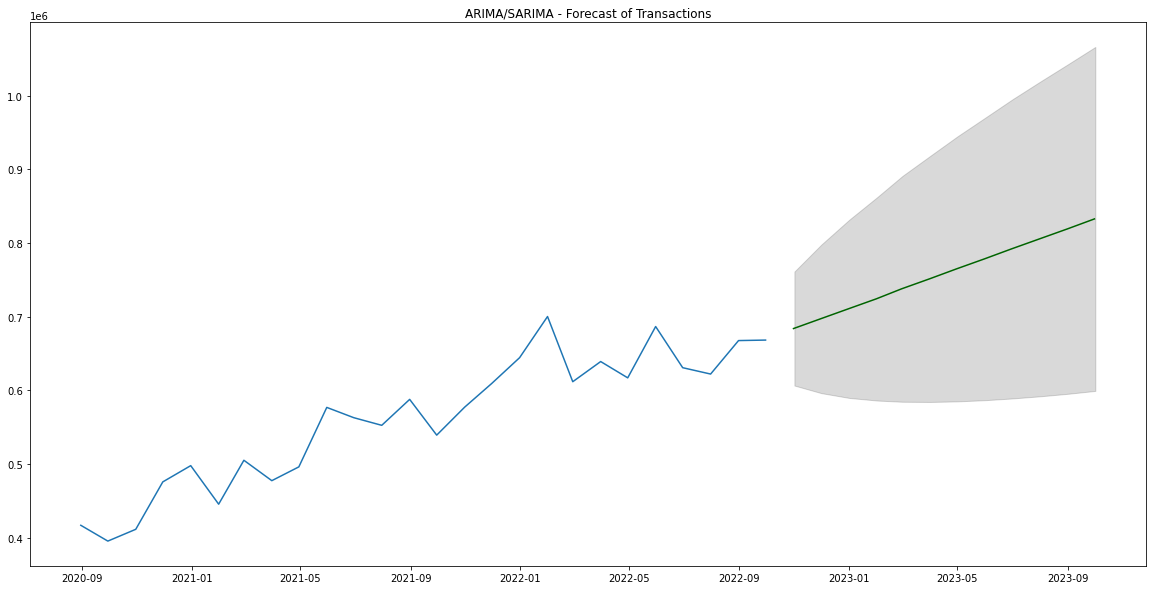

In [27]:
# forecasting for n periods

def forecast(ARIMA_model, periods=12):

    # forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')
    
    # make series for plotting purpose
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # plot
    plt.figure(figsize=(20,10))
    plt.plot(df["Merchant 1"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Transactions")
    plt.show()

forecast(ARIMA_model)

## SARIMA

In [28]:
# ARIMA with seasonal=True
# SARIMA model setup

SARIMA_model = auto_arima(df['Merchant 1'], 
                      start_p=1,              # order of the autoreg (n. lags) of the model
                      start_q=1,
                      start_P=0,              # order of the autoreg portion of the seasonal model
                      test='adf',             
                      max_p=3, max_q=3,       
                      m=12,                   # period of seasonal differencing (monthly=12)
                                              # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,                 # automatic
                      D=1,                    # order of the seasonal differencing
                      seasonal=True,          # introducing seasonality
                      trace=False,             
                      error_action='warn',    
                      suppress_warnings=True,
                      stepwise=True)          # identifies optimal model parameters

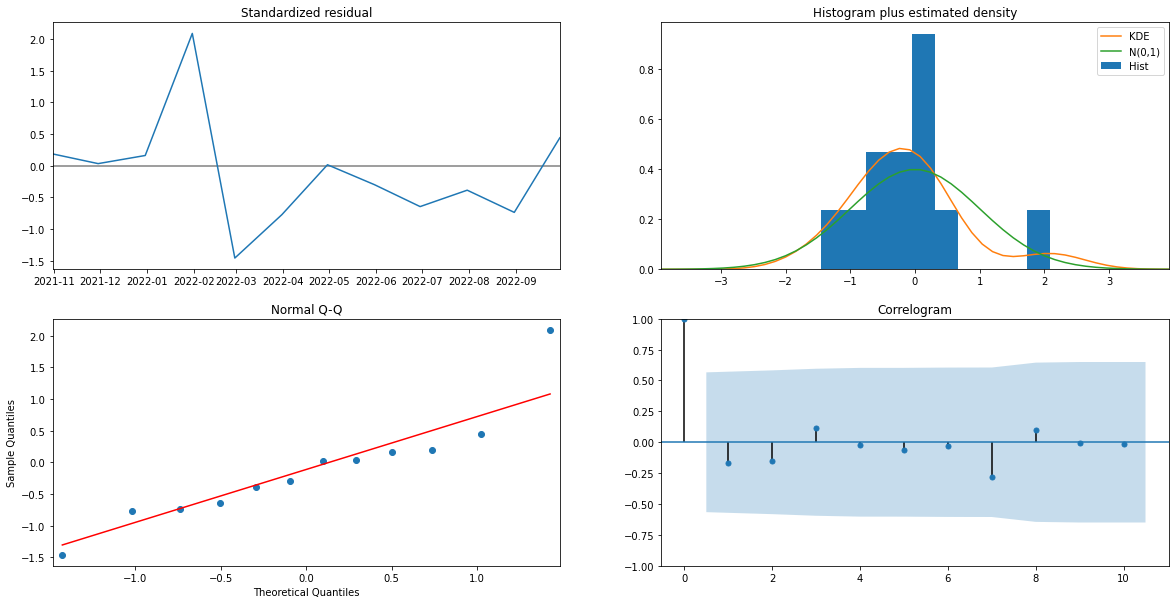

In [29]:
# SARIMA model diagnostics

SARIMA_model.plot_diagnostics(figsize=(20,10))
plt.show()

In [30]:
# SARIMA model summary

SARIMA_model.summary()

# for M1 p-value < 0.05 => significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   26
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -146.113
Date:                            Tue, 22 Nov 2022   AIC                            300.226
Time:                                    11:24:53   BIC                            302.165
Sample:                                08-31-2020   HQIC                           299.508
                                     - 09-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6703      0.298     -2.246      0.025      -1.255      -0.085
ma.L1         -0.9059      0.110     -8.243      0.000      -1.121      -0.691
ma.S.L12      -0.2000      0.283     -0.706      0.480      -0.756       0.355
sigma2      2.899e+09   1.91e-11   1.52e+20      0.000     2.9e+09     2.9e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 3.87
Prob(Q):                              0.51   Prob(JB):                         0.14
Heteroskedasticity (H):               0.29   Skew:                             1.11
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+36. Standard errors may be unstable.
"""

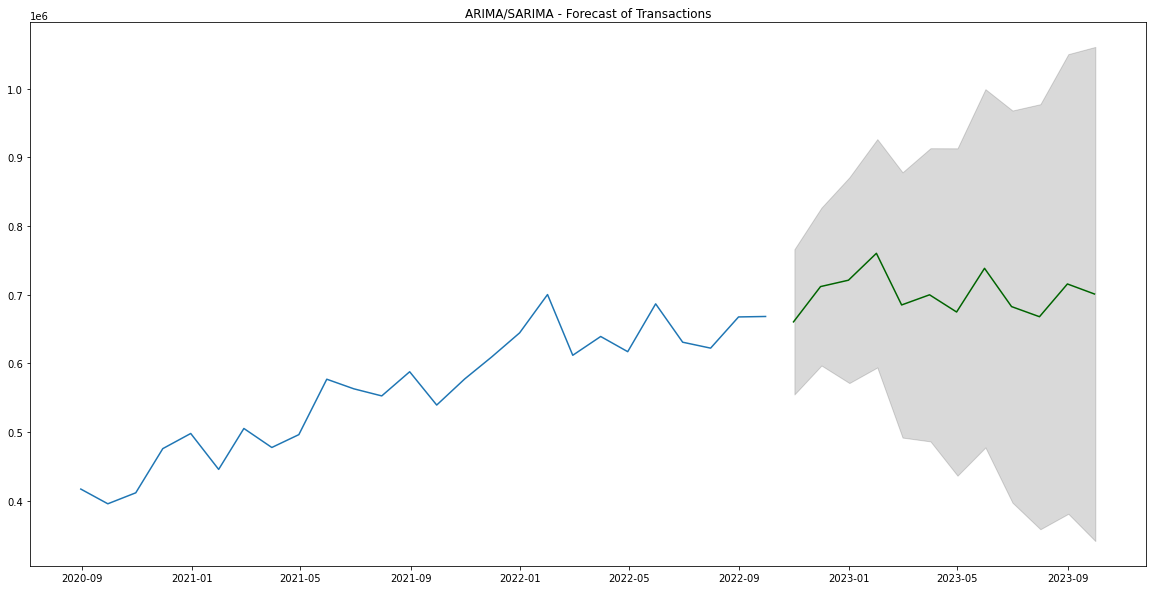

In [31]:
# forecasting for n periods
# n = 12

forecast(SARIMA_model)

## SARIMAX

In [32]:
# ARIMA uses loop and grid search for optimal values of p, d, q
# SARIMAX does the same +
# using nested loop and grid search for the seasonal values of p, d, q

In [33]:
# to forecast multiple timesteps into the future
# we need to include the months as an exogenous variable to be forecasted as well

df['month_index'] = df.index.month

In [34]:
df['month_index'][:13]

Month
2020-08-31     8
2020-09-30     9
2020-10-31    10
2020-11-30    11
2020-12-31    12
2021-01-31     1
2021-02-28     2
2021-03-31     3
2021-04-30     4
2021-05-31     5
2021-06-30     6
2021-07-31     7
2021-08-31     8
Freq: M, Name: month_index, dtype: int64

In [35]:
# SARIMAX model setup

SARIMAX_model = auto_arima(df[['Merchant 1']], 
                           exogenous=df[['month_index']],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=False,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)

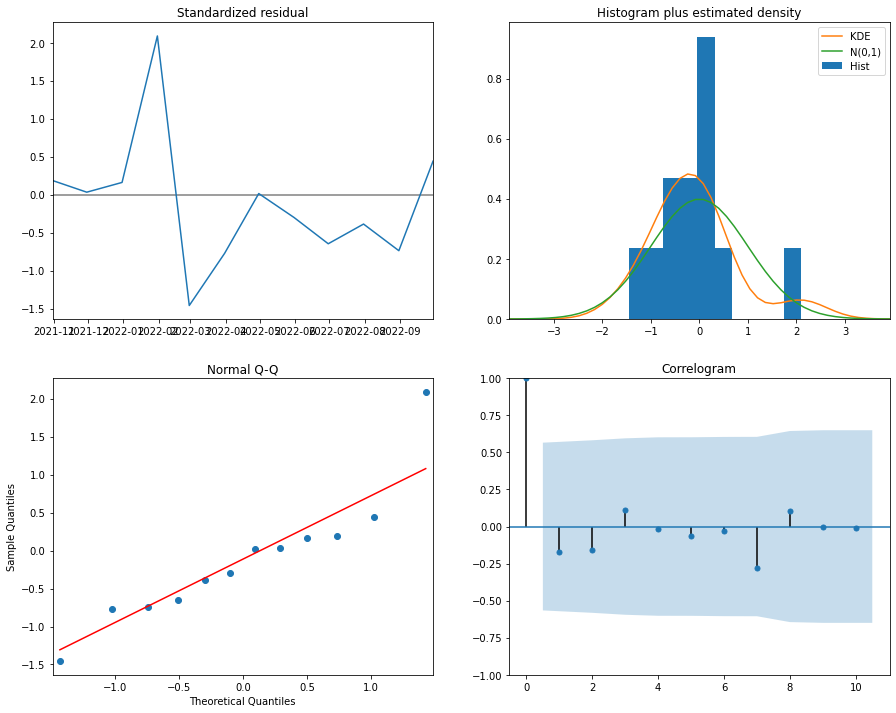

In [36]:
# SARIMAX model diagnostics

SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [37]:
# SARIMAX model summary

SARIMAX_model.summary()

# for M1 p-value < 0.05 => significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   26
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -146.113
Date:                            Tue, 22 Nov 2022   AIC                            300.226
Time:                                    11:25:11   BIC                            302.165
Sample:                                08-31-2020   HQIC                           299.508
                                     - 09-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6703      0.298     -2.246      0.025      -1.255      -0.085
ma.L1         -0.9059      0.110     -8.243      0.000      -1.121      -0.691
ma.S.L12      -0.2000      0.283     -0.706      0.480      -0.756       0.355
sigma2      2.899e+09   1.91e-11   1.52e+20      0.000     2.9e+09     2.9e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 3.87
Prob(Q):                              0.51   Prob(JB):                         0.14
Heteroskedasticity (H):               0.29   Skew:                             1.11
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+36. Standard errors may be unstable.
"""

In [38]:
# forecasting for n periods
# adding month_index for forecast_df

def sarimax_forecast(SARIMAX_model, periods=12):

    # forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True,
                                            # including exogenous variable
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    #fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # plot
    plt.figure(figsize=(20,10))
    plt.plot(df["Merchant 1"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Transactions")
    plt.show()

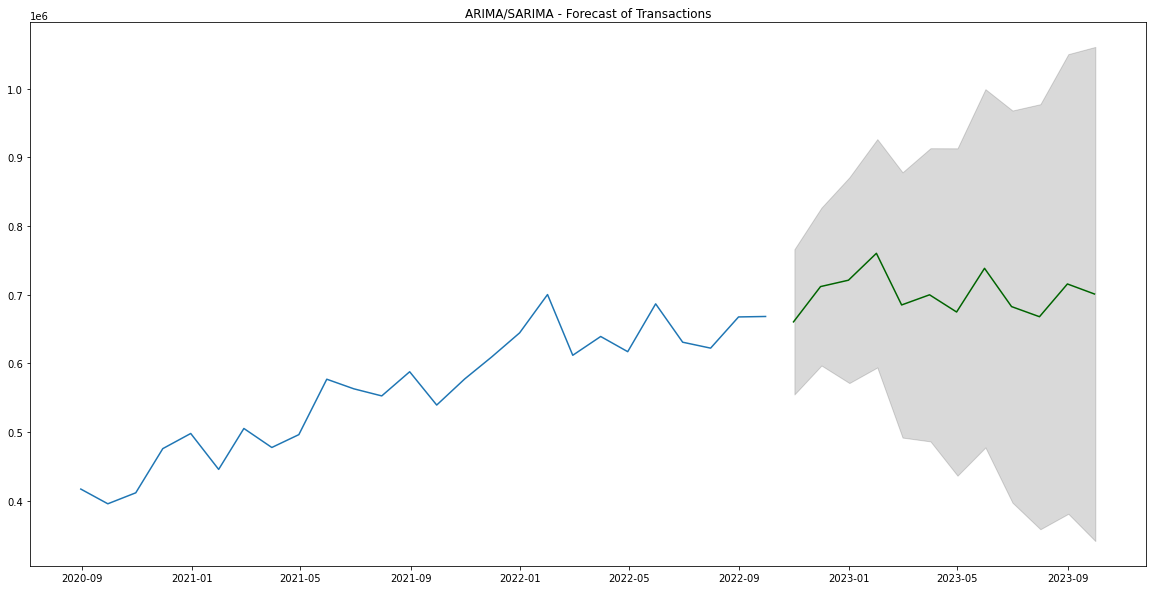

In [39]:
# forecasting for n periods
# n = 12

forecast(SARIMAX_model)

# M1 train-test split to use

In [40]:
df[:1]

,Merchant 1,month_index
Month,,
2020-08-31,416772.0,8


In [41]:
test_size = 0.8

train_rows = round(len(df) * test_size)
test_rows =  len(df) - train_rows

train_rows, test_rows

(21, 5)

In [42]:
train = pd.DataFrame({"Merchant 1" : df["Merchant 1"][:train_rows].values,
                      'Month' : df["Merchant 1"][:train_rows].index})
train = train.set_index('Month')
train.shape

(21, 1)

In [43]:
test = pd.DataFrame({"Merchant 1" : df["Merchant 1"][train_rows:].values,
                      'Month' : df["Merchant 1"][train_rows:].index})
test = test.set_index('Month')
test.shape

(5, 1)

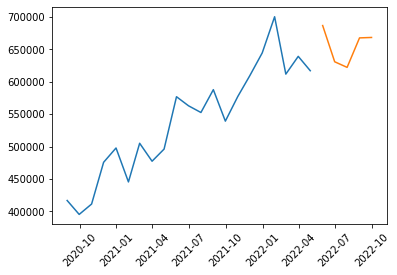

In [44]:
plt.plot(train)
plt.plot(test)
plt.xticks(rotation=45)
plt.show()

## M1 SARIMAX train

In [45]:
# to forecast multiple timesteps into the future
# we need to include the months as an exogenous variable to be forecasted as well

train['month_index'] = train.index.month
test['month_index'] = test.index.month

In [46]:
# SARIMAX model setup
# working with test_size = 0.8
# not working with test_size =0.7

SARIMAX2_model = auto_arima(train[['Merchant 1']], 
                           exogenous=train[['month_index']],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=False,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)

In [47]:
# SARIMAX model summary

SARIMAX2_model.summary()

# for M1 p-value < 0.05 => significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   21
Model:             SARIMAX(1, 2, 1)x(0, 1, [], 12)   Log Likelihood                 -86.693
Date:                             Tue, 22 Nov 2022   AIC                            179.385
Time:                                     11:25:24   BIC                            179.223
Sample:                                 08-31-2020   HQIC                           177.380
                                      - 04-30-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6842      0.304     -2.250      0.024      -1.280      -0.088
ma.L1         -0.9373      0.064    -14.741      0.000      -1.062      -0.813
sigma2      3.356e+09   1.67e-11   2.01e+20      0.000    3.36e+09    3.36e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.34   Prob(JB):                         0.53
Heteroskedasticity (H):               7.47   Skew:                             1.01
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+36. Standard errors may be unstable.
"""

## M1 SARIMAX test performance

In [48]:
# forecasting for n periods
# adding month_index for forecast_df
# adding train and test splits into function
# periods = 3 as 3 months in test split

def sarimax_forecast_train(SARIMAX_model, train, test, periods=test_rows):

    # forecast
    n_periods = periods

    df = train.copy(deep=True) # taking only train part same df name
                               # to fasten code reproduction

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    #fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(20,10))
    plt.plot(df["Merchant 1"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.plot(test, color='#1f76b4')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Transactions")
    plt.show()

    # error
    results = pd.DataFrame({'historical' : test['Merchant 1'].values,
                            'prediction' : fitted.values})
    print(results)
    rmse = sqrt(sklearn.metrics.mean_squared_error(results['historical'].values, results['prediction'].values))
    print('Test RMSE: %.3f' % rmse)

In [49]:
# predict

SARIMAX2_model.predict(n_periods=test_rows)

2022-05-31    722782.644514
2022-06-30    688795.963321
2022-07-31    689336.215593
2022-08-31    714288.783405
2022-09-30    669977.260828
Freq: M, dtype: float64

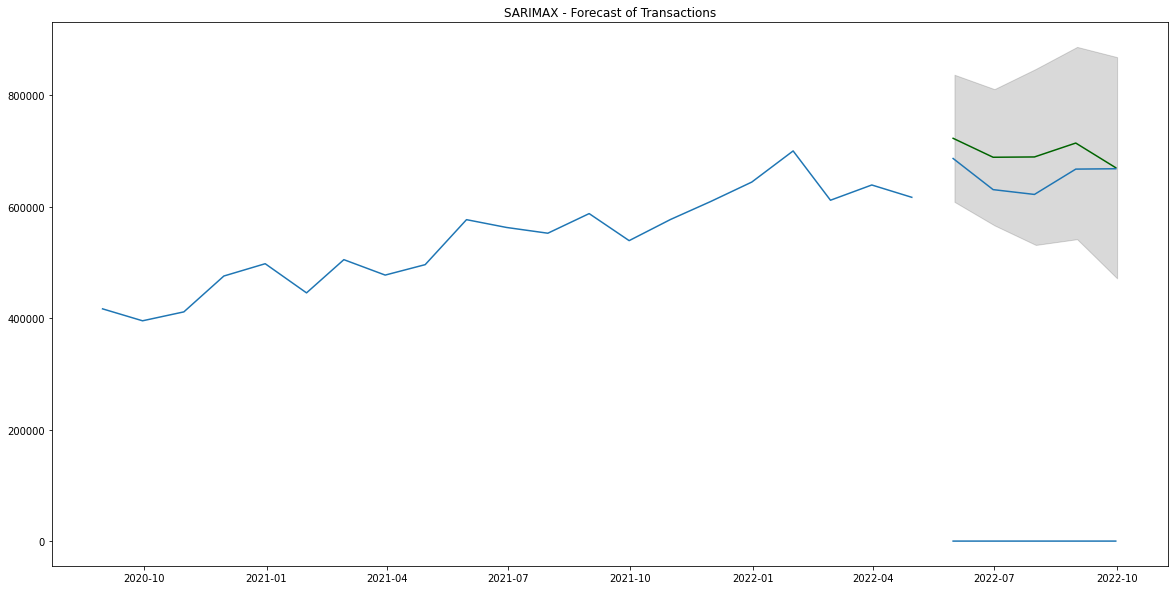

   historical     prediction
0    686572.0  722782.644514
1    630707.0  688795.963321
2    622073.0  689336.215593
3    667523.0  714288.783405
4    668189.0  669977.260828
Test RMSE: 47749.586


In [50]:
# comparing actual test vs predict

sarimax_forecast_train(SARIMAX2_model, train, test, periods=test_rows)